# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# having a look at the three datasets
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


118 seems to be a really high number for age. It is a possible outlier.

In [7]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [8]:
portfolio.nunique

<bound method DataFrame.nunique of                        channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e

In [9]:
portfolio.channels.unique

<bound method Series.unique of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

Each record in the channels column is a list itself.

## Data Cleaning

### Cleaning Portfolio dataset

In [10]:
# rename id column to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [11]:
# encode channels column
for i, j in portfolio.iterrows():
    for k in ['web', 'email', 'social', 'mobile']:
        if k in portfolio.loc[i, 'channels']:
            portfolio.loc[i, k] = 1
        else:
            portfolio.loc[i, k] = 0
portfolio.drop(columns='channels', inplace=True)

In [12]:
# encode offer_type column

for i, j in portfolio.iterrows():
    for k in ['bogo', 'informational', 'discount']:
        if k in portfolio.loc[i, 'offer_type']:
            portfolio.loc[i, k] = 1
        else:
            portfolio.loc[i, k] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [13]:
portfolio.head()

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# checking for duplicate entries
portfolio.duplicated().sum()

0

No duplicates.

### Cleaning profile dataset

In [15]:
# rename id column to customer_id
profile.rename(columns={'id': 'customer_id'}, inplace=True)

Since 118 was an outlier :-

In [16]:
profile.where(profile.age==118).count()

age                 2175
became_member_on    2175
gender                 0
customer_id         2175
income                 0
dtype: int64

There are way too many values with the age 118. We'll just replace the age with null values there.

In [17]:
profile.age.replace(118, np.nan, inplace=True)

In [18]:
# convert to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [19]:
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [20]:
# drop missing data rows
profile.dropna(inplace=True)

In [21]:
profile.shape

(14825, 5)

In [22]:
# Encode gender column
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [23]:
# segrgating year and month from became_member_on column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

### Cleaning transcript data

In [24]:
# rename person column to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [25]:
# Segregating amount and offer_id from value column

def offer_id(value):
    """
    Function to extract offer id from value column
    Input: value column
    Output: extracted offer id as a list
    """
    if list(value.keys())[0] in ['offer id', 'offer_id']:
        return list(value.values())[0]
    
def amount(value):
    """
    Function to extract amount from value column
    Input: value column
    Output: extracted amount as a list
    """
    if list(value.keys())[0] in ['amount']:
        return list(value.values())[0]
    
transcript['offer_id'] = transcript.value.apply(offer_id)
transcript['amount'] = transcript.value.apply(amount)

# converting amount type to float
transcript.amount.astype('float')

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
306504     4.89
306505     4.48
306506      NaN
306507      NaN
306508     1.19
306509      NaN
306510    14.31
306511     2.37
306512     6.92
306513    12.73
306514     8.20
306515     2.60
306516     9.20
306517    11.70
306518    40.67
306519    31.13
306520     1.64
306521    17.35
306522     4.42
306523    18.35
306524    25.14
306525    43.58
306526    22.64
306527      NaN
306528     2.20
306529     1.59
306530     9.53
306531     3.61
306532     3.53
306533     4.05
Name: amount, Length: 30

In [26]:
# drop value column
transcript.drop(columns=['value'], inplace=True)
# drop rows from transcript dataset whose customer_id is not present in profile dataset
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [27]:
# converting time to days
transcript['time'] = transcript['time']/24.0

In [28]:
# checking for duplicate values
transcript.duplicated().sum()

374

In [29]:
# drop the duplicates value
transcript.drop_duplicates(inplace=True)

In [30]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [31]:
# the indices need to be reset
transcript.reset_index(drop=True, inplace=True)

In [32]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [33]:
# segregating 'offer received', 'offer viewed', 'offer completed' from 'transaction' in the event column
transaction = transcript[transcript.event=='transaction']
transaction.drop(columns=['offer_id', 'event'], inplace=True)
transaction.head()

C:\Users\dell\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
11032,54890f68699049c2a04d415abc25e717,0.0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [34]:
offers = transcript[transcript.event!='transaction']
offers.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [35]:
# encoding event column
for i in offers.event.unique():
    offers[i]=offers.event.apply(lambda x: 1 if x == i else 0)
offers.head()

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,customer_id,time,offer_id,amount,offer received,offer viewed,offer completed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,0,0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN,1,0,0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0


In [36]:
# dropping unnecessary columns
offers.drop(columns=['event', 'amount'], inplace=True)

In [37]:
# renaming columns
offers.rename(columns={'offer received': 'offer_received', 'offer viewed': 'offer_viewed', 'offer completed': 'offer_completed'}, inplace=True)

C:\Users\dell\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [38]:
offers.head()

,customer_id,time,offer_id,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


## Exploratory analysis

### Profile Dataset

Text(0.5, 1.0, 'Gender Distribution (1=male, 0=female)')

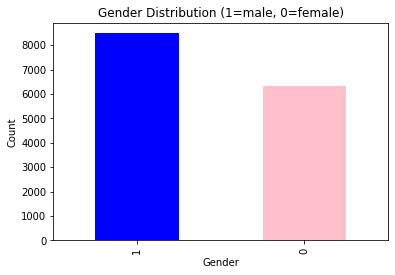

In [39]:
# Plot gender distribution
profile.gender.value_counts().plot(kind='bar', color=['blue', 'pink']);
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution (1=male, 0=female)')

More men are part of the reward program than women.

Text(0.5, 1.0, 'Age Distribution')

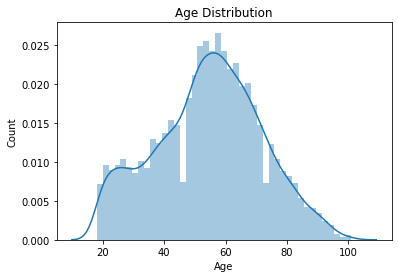

In [40]:
# plot age distribution
sns.distplot(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

The median age of a customer is 60 and most of our customers belong to age range between 40 to 70.

Text(0.5, 1.0, 'Income Distribution')

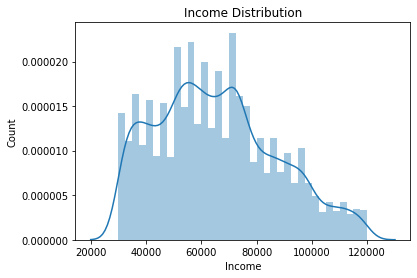

In [41]:
# plot income distribution
sns.distplot(profile['income'])
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution')

The mode here seems to be around 70K.

Text(0.5, 1.0, 'Male Income')

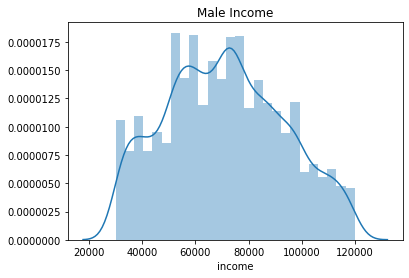

In [42]:
#lotting graphs for incomes of males and females separately
males = profile[profile['gender'] == 0]
females = profile[profile['gender'] == 1]
sns.distplot(males['income'])
plt.title('Male Income')

Somewhat a normal distribution. More men earn more than 80k than the women.

Text(0.5, 1.0, 'Female Income')

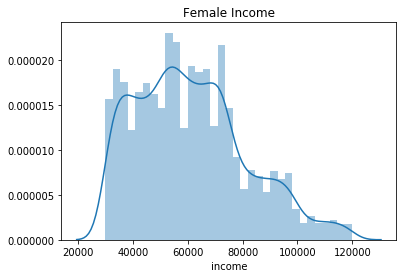

In [43]:
sns.distplot(females['income'])
plt.title('Female Income')

As we can see, this is left skewed distribution. Most women seem to earn less than 80k.

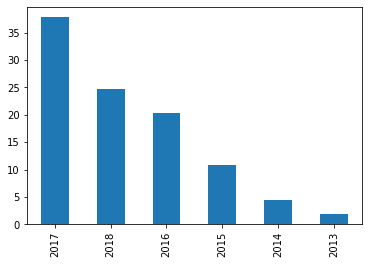

In [44]:
# Plot enrolment yearwise, as a percentage
yearwise = profile['start_year'].value_counts()
yearwise = yearwise*100/yearwise.sum()
yearwise.plot(kind='bar');

2017 has the highest number of new members. There is an increasing trend each subsequent year, 2018 being the only exception.

Plotting new enrolments with men and women segregated :

In [45]:
members = profile.groupby(['start_year', 'gender']).size().reset_index()
members.columns = ['start_year', 'gender', 'count']

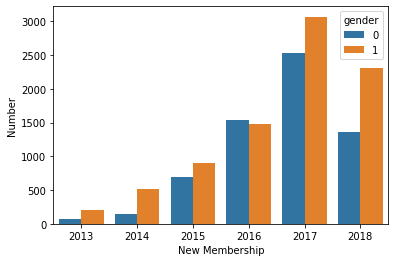

In [46]:
sns.barplot(x='start_year', y='count', hue='gender', data=members)
plt.xlabel('New Membership')
plt.ylabel('Number');

More male customers join the program every year.

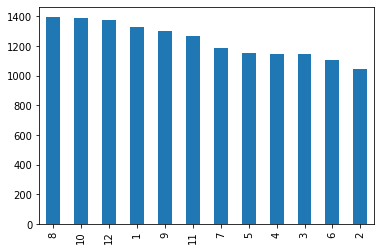

In [47]:
# Plot enrolment monthwise, as a percentage
monthwise = profile['became_member_on'].apply(lambda date: date.month).value_counts()
monthwise = monthwise*100/yearwise.sum()
monthwise.plot(kind='bar');

August seems to have the most number of new members, closely followed by October and December.

### Transaction data

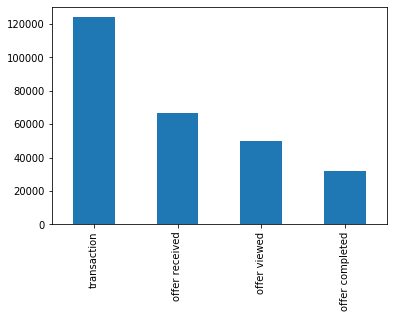

In [48]:
# plot the event type distribution
transcript['event'].value_counts().plot(kind='bar');

It seems like more number of offers sent are just viewed by the customers and not completed.

In [49]:
len(offers['customer_id'])

148431

In [50]:
len(offers['customer_id'].unique())

14820

Looks like a lot of offers have been repeated and have the same offer ID.

#### Combining all datasets

In [51]:
def merge(profile, portfolio, offers, transaction):
    """
    Function to merge and combine the cleaned datasets
    Input:
    profile: the cleaned profile dataset
    portfolio: the cleaned portfolio dataset
    offers: the cleaned offers dataset
    transaction: the cleaned transaction dataset
    Output:
    df: merged dataset
    """
    df = []
    customer_id = offers['customer_id'].unique()
    
    for i in customer_id:
        customer_profile = profile[profile['customer_id']==i]
        customer_offer = offers[offers['customer_id']==i]
        customer_transaction = transaction[transaction['customer_id']==i]
        # extract the received, completed, viewed offer data from customer offers
        offer_received = customer_offer[customer_offer['offer_received'] == 1]
        offer_completed = customer_offer[customer_offer['offer_completed'] == 1]
        offer_viewed = customer_offer[customer_offer['offer_viewed'] == 1]
        row=[]
        
        for i in range(offer_received.shape[0]):
            offer_id = offer_received.iloc[i]['offer_id']
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            duration = offer_row['duration'].values[0]
            start = offer_received.iloc[i]['time']
            end = start + duration
            # extracting offers completed within deadline
            completed = np.logical_and(offer_completed['time'] >= start, offer_completed['time'] <= end)
            # extracting offers viewed within deadline
            viewed = np.logical_and(offer_viewed['time'] >= start, offer_viewed['time'] <=end)
            # consider offer successful if it is viewed and completed within deadline
            successful = completed.sum() > 0 and viewed.sum() > 0
            # extracting transactions occured within deadline
            transaction_deadline = np.logical_and(customer_transaction['time'] >= start, customer_transaction['time'] <= end)
            transaction_data = customer_transaction[transaction_deadline]
            # calculating total amount spent
            amount_spent = transaction_data['amount'].sum()
            column = {
                'offer_id': offer_id,
                'customer_id': i,
                'time': start,
                'total_amount': amount_spent,
                'successful': int(successful),
            } 
            column.update(offer_row.iloc[0,0:].to_dict())
            column.update(customer_profile.iloc[0,:].to_dict())
            row.append(column)
        df.extend(row)    
    df = pd.DataFrame(df)
    return df

In [52]:
data = merge(profile, portfolio, offers, transaction)

In [53]:
data.head()

,age,became_member_on,bogo,customer_id,difficulty,discount,duration,email,gender,income,...,mobile,offer_id,reward,social,start_month,start_year,successful,time,total_amount,web
0,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,7,1.0,0,100000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0.0,5,2017,1,0.0,37.67,1.0
1,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,3,1.0,0,100000.0,...,1.0,5a8bc65990b245e5a138643cd4eb9837,0,1.0,5,2017,0,7.0,49.39,0.0
2,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,10,0.0,7,1.0,0,100000.0,...,1.0,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,5,2017,1,17.0,48.28,0.0
3,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,5,1.0,0,100000.0,...,1.0,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,5,2017,1,21.0,48.28,1.0
4,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,7,1.0,1,70000.0,...,1.0,2906b810c7d4411798c6938adc9daaa5,2,0.0,4,2018,0,0.0,0.00,1.0


#### Plotting success rate for each offer ID :

In [54]:
successful_count = data[['offer_id', 'successful']].groupby('offer_id').sum().reset_index()
successful_count = successful_count.sort_values('offer_id')
offer_count = data['offer_id'].value_counts()
offer_count = pd.DataFrame(list(zip(offer_count.index.values, offer_count.values)), columns=['offer_id', 'count'])
offer_count = offer_count.sort_values('offer_id')
successful_df = pd.merge(offer_count, successful_count, on="offer_id")
successful_df

,offer_id,count,successful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3078
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4841
2,2906b810c7d4411798c6938adc9daaa5,6631,3165
3,3f207df678b143eea3cee63160fa8bed,6657,514
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3410
5,5a8bc65990b245e5a138643cd4eb9837,6643,417
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3228
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,3652
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,4052
9,fafdcd668e3743c1bb461111dcafc2a4,6652,5008


In [55]:
# calculating percentage
successful_df['successful'] = (100*successful_df['successful']/successful_df['count'])
successful_df.head()

,offer_id,count,successful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299
2,2906b810c7d4411798c6938adc9daaa5,6631,47.730357
3,3f207df678b143eea3cee63160fa8bed,6657,7.721196
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523


In [56]:
successful_df[successful_df['successful']==successful_df['successful'].min()]

,offer_id,count,successful
5,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284


In [57]:
successful_df[successful_df['successful']==successful_df['successful'].max()]

,offer_id,count,successful
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628


Plotting the graph for success percentage of the offer.

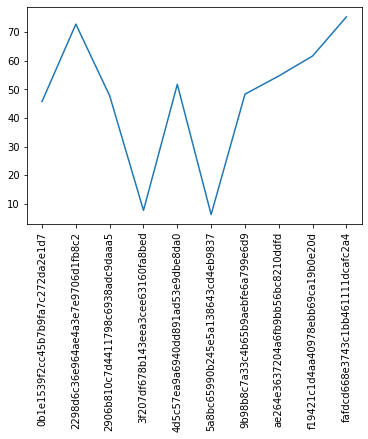

In [58]:
xx=successful_df['offer_id']
yy=successful_df['successful']
plt.plot(xx, yy)
plt.xticks(rotation=90)
plt.show()

We can conclude that offer id fafdcd668e3743c1bb461111dcafc2a4 has the highest success rate of 75% while offer id 5a8bc65990b245e5a138643cd4eb9837 has the lowest success rate of just over 6%.

## Building models

In [59]:
data.dtypes

age                        float64
became_member_on    datetime64[ns]
bogo                       float64
customer_id                 object
difficulty                   int64
discount                   float64
duration                     int64
email                      float64
gender                       int64
income                     float64
informational              float64
mobile                     float64
offer_id                    object
reward                       int64
social                     float64
start_month                  int64
start_year                   int64
successful                   int64
time                       float64
total_amount               float64
web                        float64
dtype: object

Dropping unnecessary and non-numerical columns.

In [60]:
data.drop(columns=[ 'became_member_on', 'customer_id', 'email', 'informational', 'time'], inplace=True)

In [61]:
# defining features and target
features = data.drop(columns=['successful', 'offer_id'])
target = data.filter(['successful'])

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.3)

#convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Logistic Regression

In [66]:
lr = LogisticRegression()

# fit the model with the training data
lr.fit(X_train, y_train)
predict_train = lr.predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train, predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = lr.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

print(f1_score(y_train, predict_train))
print(f1_score(y_test, predict_test))

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_score on train dataset :  0.8739205155746509
accuracy_score on test dataset :  0.878452207909378
0.8607360653014735
0.8650002783499416


### Random Forest

In [63]:
from sklearn.metrics import make_scorer, fbeta_score

In [64]:
# defining parameters
rf = RandomForestClassifier()
n_estimators = [10, 50, 100, 150, 200, 250, 300]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
grid_params = {'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
scorer = make_scorer(fbeta_score, beta=0.5)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid_params, scoring=scorer, n_iter = 100, cv = 3, random_state=42, n_jobs = 3)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [65]:
#predicting
y_pred1 = rf_random.predict(X_train)
y_pred2 = rf_random.predict(X_test)

# testing accuracy on train dataset
print(accuracy_score(y_train, y_pred1))
print(f1_score(y_train, y_pred1))

# testing accuracy on test dataset
print(accuracy_score(y_test, y_pred2))
print(f1_score(y_test, y_pred2))

0.9624919441460795
0.9605030991268154
0.9164954137637211
0.9124632198402691


Conclusion:

Random Forest Classifer works much better than Logistic Regression, hence that shall be the model of choice.

Also, Logistic Regression model performed slightly better on the test dataset than the training dataset, so we can say that there is no overfitting present while the Random Forest Classifier model performed slightly better on the training dataset than the test dataset, so we can say that there is slight overfitting present.

We built a model with accuracy above 90% that predicts whether an offer will be successful or not that is, if customer will respond to an offer.


The performance of the model can possibly be improved if:

1. We had more data to train our model on.

2. More features in the profile dataset. In the real world, just age, income and gender aren't good enough features to predict if a person responds to offers and buys coffee.